# Build `gold_prob` 

In [10]:
import os
import pandas as pd 
import numpy as np

def parse_probs(val):
    if isinstance(val, str):
        return np.fromstring(val.strip("[]"), sep=" ")
    else:
        return np.array(val)

def get_gold_prob(row, probs_col):
    option_letters = ["A", "B", "C", "D"]
    gold_idx = option_letters.index(row["gold"])
    arr = parse_probs(row[probs_col])
    return arr[gold_idx]

def process_csv(file_path, out_dir):
    df = pd.read_csv(file_path)

    # اضافه کردن ستون‌ها
    df["gold_prob_noexp"] = df.apply(lambda r: get_gold_prob(r, "probs_noexp"), axis=1)
    df["gold_prob_exp"]   = df.apply(lambda r: get_gold_prob(r, "probs_exp"), axis=1)
    df["delta_gold_prob"] = df["gold_prob_exp"] - df["gold_prob_noexp"]

    # ذخیره در پوشه جدید (out_dir)
    os.makedirs(out_dir, exist_ok=True)
    base_name = os.path.basename(file_path)
    out_path = os.path.join(out_dir, base_name.replace(".csv", "_with_goldprob.csv"))
    df.to_csv(out_path, index=False)
    print(f"✅ ذخیره شد: {out_path}")

def process_all(root_dir, out_root="processed_results"):
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(subdir, file)
                # مسیر خروجی آینه‌ای (mirror) درست کن
                rel_path = os.path.relpath(subdir, root_dir)
                out_dir = os.path.join(out_root, rel_path)
                process_csv(file_path, out_dir)

# اجرای کلی
process_all("/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa_with_goldprob", out_root="fa_with_goldprob")


✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_0_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_80_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_40_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_70_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_30_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_20_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_90_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_10_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_50_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/mistral/eval_mistral_small_3.1_60_with_goldprob_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/claude/eval_claude_3_h

# Metrics_Function

In [1]:
import pandas as pd
import glob
import os

def compute_metrics(folder: str, prefix: str) -> pd.DataFrame:
    """
    Compute accuracy, sufficiency, and similarities for all CSVs in a folder
    that start with the given prefix.
    
    Args:
        folder (str): Path to folder containing eval CSV files.
        prefix (str): Prefix of the filenames (e.g. 'eval_cohere_r_command_').
        
    Returns:
        pd.DataFrame: Summary table of metrics across versions.
    """
    files = sorted(glob.glob(os.path.join(folder, f"{prefix}*.csv")))
    results = []

    for f in files:
        print(f)
        version = os.path.splitext(os.path.basename(f))[0].split("_")[-3]
        df = pd.read_csv(f)

        # Accuracy with explanation
        acc_exp = df["is_correct_exp"].mean()

        # Accuracy without explanation (baseline)
        acc_noexp = df["is_correct_noexp"].mean() if "is_correct_noexp" in df else None

        # Sufficiency (mean prob of correct answer given explanation)
        suff = df["gold_prob_exp"].mean()

        # Similarities (may not exist in baseline)
        sim = df["similarity_with_base"].mean() if "similarity_with_base" in df else None
        sim_clean = df["similarity_with_base_clean"].mean() if "similarity_with_base_clean" in df else None
        bert_score = df['bertscore_F1_clean'].mean()

        results.append({
            "version": version,
            "accuracy_exp": acc_exp,
            "accuracy_noexp": acc_noexp,
            "sufficiency": suff,
            "similarity": sim,
            "similarity_clean": sim_clean,
            "bert_score":bert_score,
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="version").reset_index(drop=True)
    return results_df


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def plot_metrics(results_df, model_name="Model"):
    """
    Create publication-ready plots for accuracy, sufficiency, and similarity metrics.
    
    Args:
        results_df (pd.DataFrame): Results dataframe with version and metric columns
        model_name (str): Name of the model for the title
    """
    results_df["version"] = results_df["version"].astype(int)
    baseline_df = results_df[results_df["version"] == 0]
    other_df = results_df[results_df["version"] != 0].sort_values(by="version", ascending=False)
    plot_df = pd.concat([baseline_df, other_df])
    
    # Define consistent styling
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    x_pos = range(len(plot_df))
    
    # Create figure with publication-ready dimensions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), facecolor='white')
    fig.patch.set_facecolor('white')
    
    # Color scheme for consistency
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Accuracy
    axs[0].plot(x_pos, plot_df["accuracy_exp"], marker="o", linewidth=2.5, 
                markersize=8, color=colors[0], label="With Explanation", zorder=3)
    if "accuracy_noexp" in plot_df.columns:
        axs[0].plot(x_pos, plot_df["accuracy_noexp"], marker="s", linewidth=2.5, 
                    markersize=8, linestyle="--", color=colors[1], 
                    label="Without Explanation", zorder=3)
    
    axs[0].set_title("Model Accuracy", fontsize=14, fontweight='bold', pad=15)
    axs[0].set_ylabel("Accuracy Score", fontsize=12)
    axs[0].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
    axs[0].set_ylim(bottom=min(plot_df["accuracy_exp"]) * 0.95)
    
    # Plot 2: Sufficiency
    axs[1].plot(x_pos, plot_df["sufficiency"], marker="^", linewidth=2.5, 
                markersize=8, color=colors[2], zorder=3)
    axs[1].set_title("Explanation Sufficiency", fontsize=14, fontweight='bold', pad=15)
    axs[1].set_ylabel("Sufficiency Score", fontsize=12)
    axs[1].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[1].set_ylim(bottom=min(plot_df["sufficiency"]) * 0.95)
    
    # Plot 3: Similarity
    if "similarity" in plot_df.columns:
        axs[2].plot(x_pos, plot_df["similarity"], marker="o", linewidth=2.5, 
                    markersize=8, color='#C73E1D', label="Original", zorder=3)
    if "similarity_clean" in plot_df.columns:
        axs[2].plot(x_pos, plot_df["similarity_clean"], marker="^", linewidth=2.5, 
                    markersize=8, color='#7209B7', label="Cleaned", zorder=3)
    
    axs[2].set_title("Output Similarity", fontsize=14, fontweight='bold', pad=15)
    axs[2].set_ylabel("Similarity Score", fontsize=12)
    axs[2].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[2].legend(frameon=True, fancybox=True, shadow=True, loc='best')
    if "similarity" in plot_df.columns:
        axs[2].set_ylim(bottom=min(plot_df["similarity"]) * 0.95)
    
    # Common styling for all subplots
    for i, ax in enumerate(axs):
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels, fontsize=11)
        ax.set_xlabel("Constraint Level", fontsize=12, fontweight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.8)
        ax.spines['bottom'].set_linewidth(0.8)
        
        # Add subtle background shading for baseline
        ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=1)
    
    # Main title
    fig.suptitle(f"Performance Metrics Evaluation: {model_name}", 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)
    plt.show()


def plot_multi_models(dfs: dict, metric: str, title: str, save_path=None):
    """
    Create publication-ready multi-model comparison plot.
    
    Args:
        dfs (dict): Dictionary of model names and their dataframes
        metric (str): Metric column name to plot
        title (str): Plot title
        save_path (str, optional): Path to save the figure
    """
    # Create publication-ready figure
    plt.figure(figsize=(12, 7), facecolor='white')
    
    # Enhanced color palette for multiple models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Line styles for variety
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for i, (model_name, df) in enumerate(dfs.items()):
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        x_pos = range(len(plot_df))
        
        plt.plot(x_pos, plot_df[metric], 
                marker=markers[i % len(markers)], 
                linewidth=3, 
                markersize=9,
                color=colors[i % len(colors)],
                linestyle=line_styles[i % len(line_styles)],
                label=model_name,
                zorder=3)
    
    # Styling
    plt.xticks(x_pos, display_labels, fontsize=12)
    plt.xlabel("Constraint Level", fontsize=14, fontweight='bold')
    plt.ylabel(f"{metric.replace('_', ' ').title()} Score", fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Enhanced legend
    plt.legend(frameon=True, fancybox=True, shadow=True, 
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
    
    # Grid and styling
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # Highlight baseline region
    plt.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=1)
    
    # Removed the bottom constraint level annotation text
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12, right=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    plt.show()


def plot_heatmap_comparison(dfs: dict, metrics: list, title: str = "Model Performance Heatmap"):
    """
    Create a heatmap comparison of multiple metrics across models and constraint levels.
    
    Args:
        dfs (dict): Dictionary of model names and their dataframes
        metrics (list): List of metric column names
        title (str): Heatmap title
    """
    # Prepare data for heatmap
    heatmap_data = []
    model_names = []
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for model_name, df in dfs.items():
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        for metric in metrics:
            if metric in plot_df.columns:
                heatmap_data.append(plot_df[metric].values)
                model_names.append(f"{model_name} - {metric.replace('_', ' ').title()}")
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, len(model_names) * 0.6), facecolor='white')
    
    heatmap_array = np.array(heatmap_data)
    im = ax.imshow(heatmap_array, cmap='RdYlGn', aspect='auto', interpolation='nearest')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Performance Score', fontsize=12, fontweight='bold')
    
    # Labels
    ax.set_xticks(range(len(display_labels)))
    ax.set_xticklabels(display_labels, rotation=45, ha='right')
    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names, fontsize=10)
    
    ax.set_xlabel("Constraint Level", fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add value annotations
    for i in range(len(model_names)):
        for j in range(len(display_labels)):
            text = ax.text(j, i, f'{heatmap_array[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [17]:
def plot_similarity_heatmap(dfs: dict, language: str = "English", save_path: str = None):
    """
    Create a publication-ready heatmap of embedding similarity across models and constraint levels.

    Args:
        dfs (dict): Dictionary where keys are model names and values are DataFrames containing 'version' and 'similarity_clean' columns.
        language (str): Language label for the plot title (e.g., "English" or "Persian").
        save_path (str, optional): Path to save the heatmap image.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from matplotlib.patches import Rectangle

    # Prepare heatmap data
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    heatmap_data = []
    model_names = []

    for model_name, df in dfs.items():
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        # Choose column (prefer cleaned version if available)
        if "similarity_clean" in plot_df.columns:
            heatmap_data.append(plot_df["similarity_clean"].values)
        elif "similarity" in plot_df.columns:
            heatmap_data.append(plot_df["similarity"].values)
        else:
            raise ValueError(f"Neither 'similarity' nor 'similarity_clean' column found for model {model_name}")
        
        model_names.append(model_name)

    heatmap_array = np.array(heatmap_data)

    # Create figure with better proportions
    fig, ax = plt.subplots(figsize=(12, len(model_names) * 0.7 + 1.5), facecolor='white')
    
    # Use a professional academic colormap
    # Options: RdYlGn_r (red-yellow-green), coolwarm, viridis, or custom
    from matplotlib.colors import LinearSegmentedColormap
    
    # Custom colormap: white -> light blue -> dark blue (better for print/grayscale)
    colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c', '#08306b']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=n_bins)
    
    # Alternative: Viridis (colorblind-friendly)
    # cmap = 'viridis'
    
    # Alternative: RdYlGn reversed (red=low, green=high)
    # cmap = 'RdYlGn'

    # Draw heatmap with improved styling
    sns.heatmap(
        heatmap_array,
        cmap=cmap,
        annot=True,
        fmt=".3f",
        linewidths=1.0,
        linecolor='white',
        cbar_kws={
            'label': 'Embedding Similarity',
            'shrink': 0.8,
            'aspect': 20,
            'pad': 0.02
        },
        vmin=0.5,  # Set min value for better color contrast
        vmax=0.95,  # Set max value
        ax=ax,
        annot_kws={'fontsize': 9, 'fontweight': 'medium'}
    )

    # Improve colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Embedding Similarity', fontsize=12, fontweight='bold', rotation=270, labelpad=20)

    # Customize labels and titles
    ax.set_xticks(np.arange(len(display_labels)) + 0.5)
    ax.set_xticklabels(display_labels, fontsize=11)
    ax.set_yticks(np.arange(len(model_names)) + 0.5)
    ax.set_yticklabels(model_names, rotation=0, fontsize=11, va='center')

    ax.set_xlabel("Constraint Level", fontsize=13, fontweight='bold', labelpad=10)
    ax.set_ylabel("Model", fontsize=13, fontweight='bold', labelpad=10)
    ax.set_title(
        f"Embedding Similarity Across Models ({language})", 
        fontsize=15, 
        fontweight='bold', 
        pad=20
    )

    # Add subtle baseline highlight with better styling
    rect = Rectangle(
        (0, 0), 
        1, 
        len(model_names), 
        fill=True, 
        facecolor='none',
        edgecolor='darkgray',
        linewidth=2.5,
        linestyle='--',
        alpha=0.6,
        zorder=10
    )
    ax.add_patch(rect)

    # Improve grid and spines
    ax.tick_params(axis='both', which='both', length=0)
    for spine in ax.spines.values():
        spine.set_edgecolor('#333333')
        spine.set_linewidth(1.5)

    # Tidy layout
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Heatmap saved to: {save_path}")

    plt.show()

## Claude

In [3]:
claude_df = compute_metrics("claude", "eval_claude_3_haiku_")
claude_df

claude/eval_claude_3_haiku_fa_0_with_goldprob.csv
claude/eval_claude_3_haiku_fa_10_with_goldprob.csv
claude/eval_claude_3_haiku_fa_20_with_goldprob.csv
claude/eval_claude_3_haiku_fa_30_with_goldprob.csv
claude/eval_claude_3_haiku_fa_40_with_goldprob.csv
claude/eval_claude_3_haiku_fa_50_with_goldprob.csv
claude/eval_claude_3_haiku_fa_60_with_goldprob.csv
claude/eval_claude_3_haiku_fa_70_with_goldprob.csv
claude/eval_claude_3_haiku_fa_80_with_goldprob.csv
claude/eval_claude_3_haiku_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.783805,0.478497,0.747764,None,NaN,0.998450
1,10,0.688493,0.478497,0.651099,None,0.641761,0.574186
2,20,0.719101,0.478497,0.685721,None,0.746146,0.666307
3,30,0.745060,0.478497,0.708011,None,0.796191,0.713594
4,40,0.749322,0.478497,0.716315,None,0.826505,0.748438
5,50,0.750872,0.478497,0.720418,None,0.844635,0.770858
6,60,0.760558,0.478497,0.724539,None,0.851756,0.780144
7,70,0.765595,0.478497,0.728309,None,0.854943,0.786777
8,80,0.765207,0.478497,0.729720,None,0.862874,0.796979
9,90,0.764820,0.478497,0.728880,None,0.868333,0.803958


## GPT

In [4]:
gpt_df = compute_metrics("gpt-4o-mini", "eval_gpt_4o_mini_")
gpt_df

gpt-4o-mini/eval_gpt_4o_mini_fa_0_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_10_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_20_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_30_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_40_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_50_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_60_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_70_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_80_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.826036,0.479272,0.791861,None,NaN,1.000000
1,10,0.645486,0.479272,0.607502,None,0.584329,0.547480
2,20,0.679194,0.479272,0.635490,None,0.676961,0.608354
3,30,0.710190,0.479272,0.668659,None,0.742607,0.650168
4,40,0.731112,0.479272,0.688366,None,0.794435,0.691038
5,50,0.749709,0.479272,0.703853,None,0.831390,0.727993
6,60,0.753584,0.479272,0.714209,None,0.855248,0.752997
7,70,0.767532,0.479272,0.726096,None,0.872703,0.772358
8,80,0.775668,0.479272,0.736458,None,0.888897,0.791739
9,90,0.782255,0.479272,0.744429,None,0.902828,0.808863


## Cohere

In [5]:
cohere_df = compute_metrics("cohere", "eval_cohere_r_command_")
cohere_df

cohere/eval_cohere_r_command_fa_0_with_goldprob.csv
cohere/eval_cohere_r_command_fa_10_with_goldprob.csv
cohere/eval_cohere_r_command_fa_20_with_goldprob.csv
cohere/eval_cohere_r_command_fa_30_with_goldprob.csv
cohere/eval_cohere_r_command_fa_40_with_goldprob.csv
cohere/eval_cohere_r_command_fa_50_with_goldprob.csv
cohere/eval_cohere_r_command_fa_60_with_goldprob.csv
cohere/eval_cohere_r_command_fa_70_with_goldprob.csv
cohere/eval_cohere_r_command_fa_80_with_goldprob.csv
cohere/eval_cohere_r_command_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.692367,0.478497,0.661227,None,NaN,1.000000
1,10,0.613328,0.478497,0.576517,None,0.525559,0.518569
2,20,0.631926,0.478497,0.601882,None,0.656978,0.605296
3,30,0.648586,0.478497,0.617286,None,0.729514,0.652528
4,40,0.672220,0.478497,0.633912,None,0.777698,0.686023
5,50,0.666796,0.478497,0.635008,None,0.807805,0.712555
6,60,0.670670,0.478497,0.637668,None,0.827879,0.732800
7,70,0.675707,0.478497,0.644664,None,0.845101,0.749985
8,80,0.683069,0.478497,0.649870,None,0.860100,0.766523
9,90,0.680356,0.478497,0.648612,None,0.873420,0.781438


## LLama

In [6]:
llama_df = compute_metrics("llama", "eval_llama_4_maverik_")
llama_df

llama/eval_llama_4_maverik_masked_0_with_goldprob.csv
llama/eval_llama_4_maverik_masked_10_with_goldprob.csv
llama/eval_llama_4_maverik_masked_20_with_goldprob.csv
llama/eval_llama_4_maverik_masked_30_with_goldprob.csv
llama/eval_llama_4_maverik_masked_40_with_goldprob.csv
llama/eval_llama_4_maverik_masked_50_with_goldprob.csv
llama/eval_llama_4_maverik_masked_60_with_goldprob.csv
llama/eval_llama_4_maverik_masked_70_with_goldprob.csv
llama/eval_llama_4_maverik_masked_80_with_goldprob.csv
llama/eval_llama_4_maverik_masked_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.849671,0.478497,0.806687,None,NaN,1.000000
1,10,0.653623,0.478497,0.612349,None,0.547995,0.500289
2,20,0.704766,0.478497,0.657773,None,0.674266,0.607564
3,30,0.735374,0.478497,0.688907,None,0.747198,0.663932
4,40,0.755909,0.478497,0.708394,None,0.790834,0.698279
5,50,0.771406,0.478497,0.722975,None,0.817820,0.722402
6,60,0.777606,0.478497,0.730638,None,0.837806,0.741597
7,70,0.773731,0.478497,0.735538,None,0.850494,0.755161
8,80,0.791166,0.478497,0.746862,None,0.861219,0.767011
9,90,0.796203,0.478497,0.749993,None,0.870873,0.778610


In [7]:
llama_df_scout = compute_metrics("llama_scout", "eval_llama_4_scout_")
llama_df_scout

llama_scout/eval_llama_4_scout_masked_0_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_10_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_20_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_30_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_40_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_50_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_60_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_70_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_80_with_goldprob.csv
llama_scout/eval_llama_4_scout_masked_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.796203,0.477722,0.758107,None,NaN,1.000000
1,10,0.685006,0.477722,0.643404,None,0.560411,0.523166
2,20,0.706703,0.477722,0.668596,None,0.668836,0.610562
3,30,0.719876,0.477722,0.682933,None,0.731783,0.657867
4,40,0.730337,0.477722,0.692573,None,0.773213,0.690018
5,50,0.745835,0.477722,0.708273,None,0.803049,0.715804
6,60,0.743123,0.477722,0.706919,None,0.820828,0.735147
7,70,0.757071,0.477722,0.717977,None,0.837295,0.751106
8,80,0.757846,0.477722,0.720668,None,0.852477,0.766777
9,90,0.763657,0.477722,0.726787,None,0.859651,0.775041


## Deepseek

In [8]:
deepseek_df = compute_metrics("deepseek", "eval_deepseek_v3.1_")
deepseek_df

deepseek/eval_deepseek_v3.1_0_with_goldprob.csv
deepseek/eval_deepseek_v3.1_10_with_goldprob.csv
deepseek/eval_deepseek_v3.1_20_with_goldprob.csv
deepseek/eval_deepseek_v3.1_30_with_goldprob.csv
deepseek/eval_deepseek_v3.1_40_with_goldprob.csv
deepseek/eval_deepseek_v3.1_50_with_goldprob.csv
deepseek/eval_deepseek_v3.1_60_with_goldprob.csv
deepseek/eval_deepseek_v3.1_70_with_goldprob.csv
deepseek/eval_deepseek_v3.1_80_with_goldprob.csv
deepseek/eval_deepseek_v3.1_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.802402,0.478497,0.766077,None,NaN,1.000000
1,10,0.667571,0.478497,0.621031,None,0.570013,0.534920
2,20,0.693142,0.478497,0.649168,None,0.654810,0.605716
3,30,0.717939,0.478497,0.670463,None,0.707658,0.639727
4,40,0.728787,0.478497,0.685542,None,0.743207,0.663624
5,50,0.742348,0.478497,0.694888,None,0.772465,0.682059
6,60,0.738473,0.478497,0.699196,None,0.789537,0.695770
7,70,0.747385,0.478497,0.703200,None,0.805601,0.708551
8,80,0.759008,0.478497,0.713849,None,0.820477,0.721878
9,90,0.767532,0.478497,0.721202,None,0.834147,0.735319


## Gemini

In [9]:
gemini_df = compute_metrics("gemini", "eval_gemini_2.0_flash_")
gemini_df

gemini/eval_gemini_2.0_flash_fa_0_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_10_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_20_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_30_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_40_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_50_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_60_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_70_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_80_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.820612,0.478497,0.780864,None,NaN,1.000000
1,10,0.692755,0.478497,0.650338,None,0.557314,0.537184
2,20,0.736149,0.478497,0.693264,None,0.692414,0.616269
3,30,0.760558,0.478497,0.718593,None,0.768547,0.665283
4,40,0.781480,0.478497,0.740963,None,0.807795,0.695544
5,50,0.797365,0.478497,0.751521,None,0.831511,0.719735
6,60,0.800852,0.478497,0.758141,None,0.845797,0.732377
7,70,0.807826,0.478497,0.763811,None,0.857220,0.744521
8,80,0.803177,0.478497,0.765482,None,0.866516,0.753961
9,90,0.809764,0.478497,0.768477,None,0.873269,0.761065


## Mistral

In [10]:
mistral_df = compute_metrics("mistral", "eval_mistral_small_3.1_")
mistral_df

mistral/eval_mistral_small_3.1_0_with_goldprob.csv
mistral/eval_mistral_small_3.1_10_with_goldprob.csv
mistral/eval_mistral_small_3.1_20_with_goldprob.csv
mistral/eval_mistral_small_3.1_30_with_goldprob.csv
mistral/eval_mistral_small_3.1_40_with_goldprob.csv
mistral/eval_mistral_small_3.1_50_with_goldprob.csv
mistral/eval_mistral_small_3.1_60_with_goldprob.csv
mistral/eval_mistral_small_3.1_70_with_goldprob.csv
mistral/eval_mistral_small_3.1_80_with_goldprob.csv
mistral/eval_mistral_small_3.1_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean,bert_score
0,0,0.750484,0.478497,0.716347,None,NaN,1.000000
1,10,0.624177,0.478497,0.584414,None,0.517561,0.484908
2,20,0.658272,0.478497,0.618446,None,0.619578,0.577421
3,30,0.674157,0.478497,0.641659,None,0.687024,0.626794
4,40,0.693142,0.478497,0.649619,None,0.733356,0.659960
5,50,0.698179,0.478497,0.660237,None,0.773433,0.692742
6,60,0.701279,0.478497,0.667800,None,0.796232,0.716679
7,70,0.717164,0.478497,0.673798,None,0.808734,0.731297
8,80,0.707865,0.478497,0.673157,None,0.832841,0.752786
9,90,0.721813,0.478497,0.687929,None,0.853676,0.774402


# Multi_Models

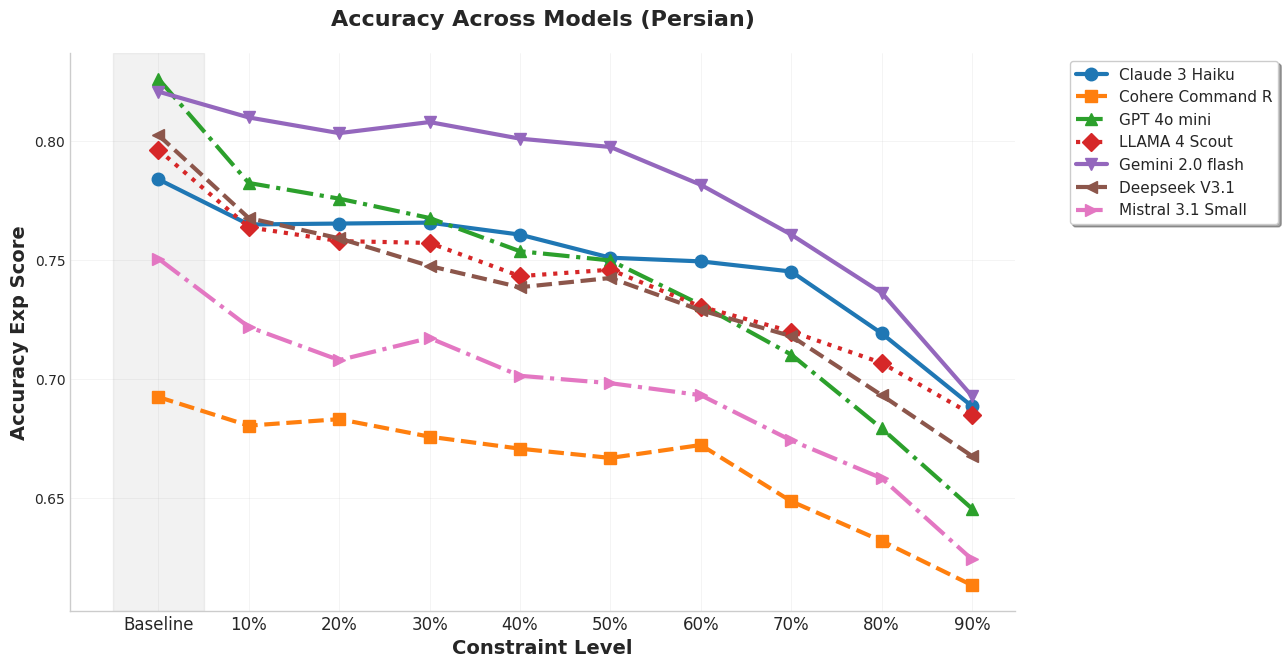

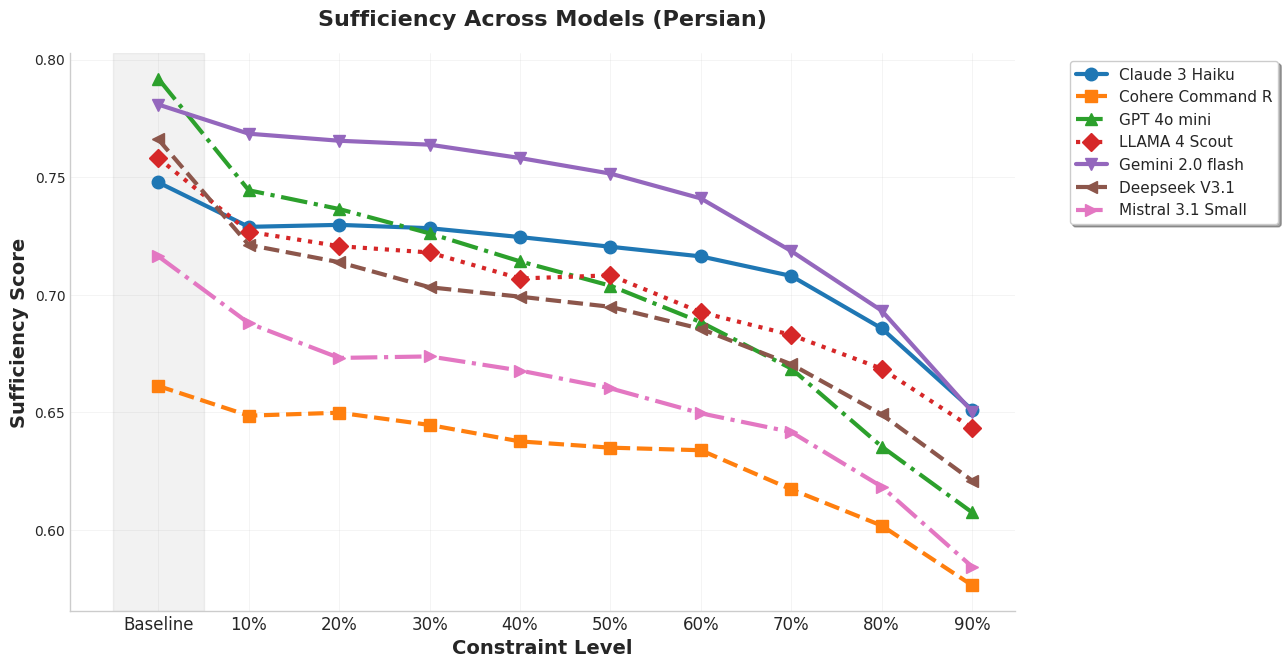

In [22]:
# دیکشنری از مدل‌ها
dfs = {
    "Claude 3 Haiku": claude_df,
    "Cohere Command R": cohere_df,
    "GPT 4o mini": gpt_df,
    "LLAMA 4 Scout": llama_df_scout,
    "Gemini 2.0 flash": gemini_df,
    "Deepseek V3.1": deepseek_df,
    "Mistral 3.1 Small": mistral_df,
}

# Accuracy
plot_multi_models(dfs, "accuracy_exp", "Accuracy Across Models (Persian)")

# Sufficiency
plot_multi_models(dfs, "sufficiency", "Sufficiency Across Models (Persian)")

# # Similarity Clean
# plot_multi_models(dfs, "similarity_clean", "Similarity Across Models (Persian)")

# plot_multi_models(dfs, "bert_score", "BertScore (Persian)")

✓ Heatmap saved to: similarity_heatmap_fa.png


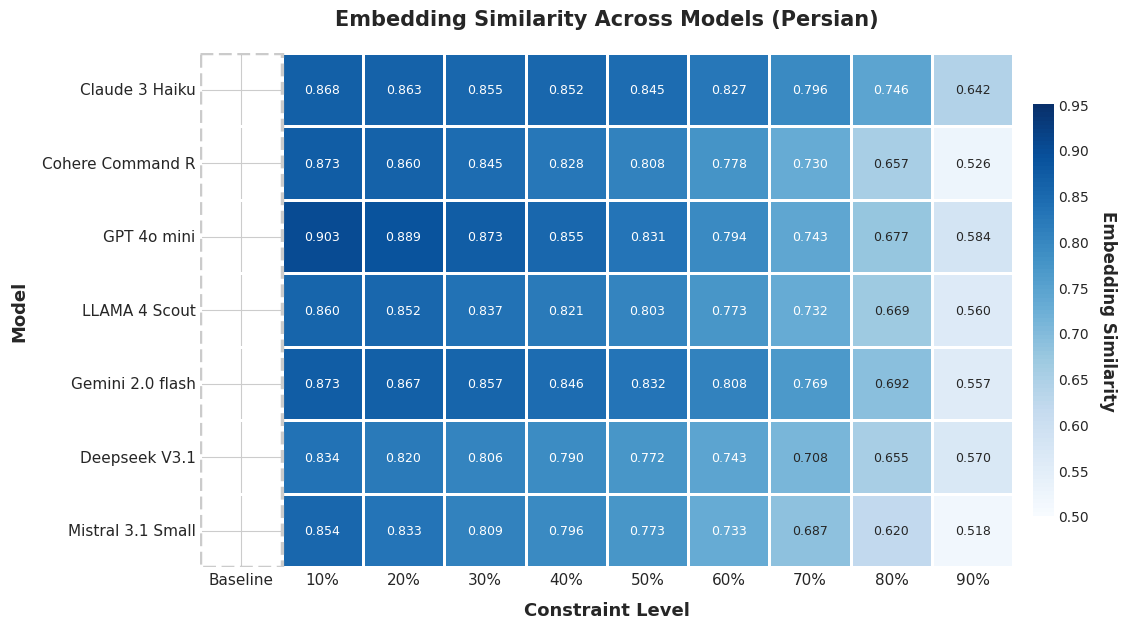

In [18]:
# فرض کن دو زبان داری:
plot_similarity_heatmap(dfs, language="Persian", save_path="similarity_heatmap_fa.png")
# plot_similarity_heatmap(english_dfs, language="English", save_path="figures/similarity_heatmap_en.png")


# LONG DF 

In [24]:
import pandas as pd

all_dfs = []
for model_name, df in dfs.items():
    # keep only needed columns
    sub = df[["version", "accuracy_exp", "sufficiency", "similarity_clean"]].copy()
    sub["model"] = model_name
    all_dfs.append(sub)

merged_df = pd.concat(all_dfs, ignore_index=True)

merged_df.tail(20)

,version,accuracy_exp,sufficiency,similarity_clean,model
50,0,0.802402,0.766077,NaN,Deepseek V3.1
51,10,0.667571,0.621031,0.570013,Deepseek V3.1
52,20,0.693142,0.649168,0.654810,Deepseek V3.1
53,30,0.717939,0.670463,0.707658,Deepseek V3.1
54,40,0.728787,0.685542,0.743207,Deepseek V3.1
55,50,0.742348,0.694888,0.772465,Deepseek V3.1
56,60,0.738473,0.699196,0.789537,Deepseek V3.1
57,70,0.747385,0.703200,0.805601,Deepseek V3.1
58,80,0.759008,0.713849,0.820477,Deepseek V3.1
59,90,0.767532,0.721202,0.834147,Deepseek V3.1


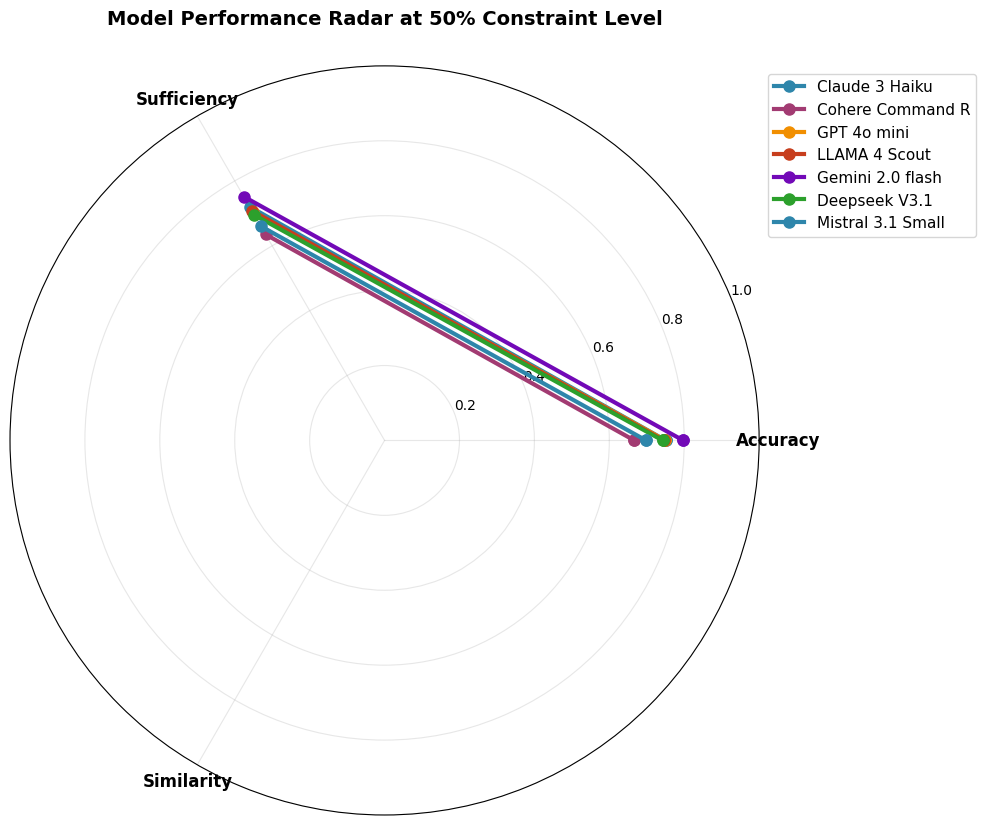

In [25]:
plot_radar_comparison(dfs)

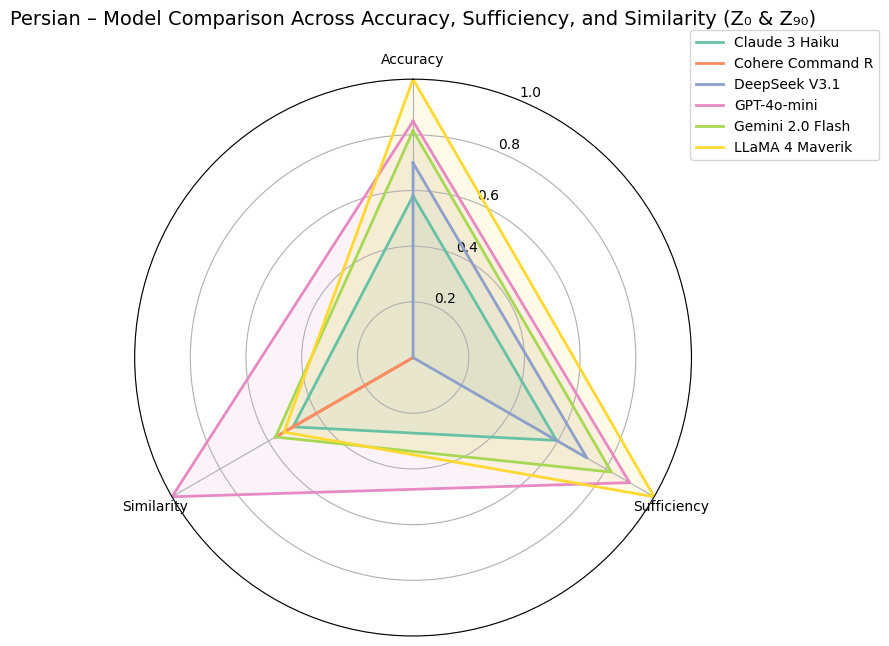

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================
# Persian radar data (acc/suff @ Z0, sim @ Z90)
# ==========================================
data_fa = {
    "Model": [
        "Claude 3 Haiku",
        "Cohere Command R",
        "DeepSeek V3.1",
        "GPT-4o-mini",
        "Gemini 2.0 Flash",
        "LLaMA 4 Maverik"
    ],
    "Accuracy": [0.7838, 0.6924, 0.8024, 0.8260, 0.8206, 0.8497],
    "Sufficiency": [0.7478, 0.6612, 0.7661, 0.7919, 0.7809, 0.8067],
    "Similarity": [0.8683, 0.8734, 0.8341, 0.9028, 0.8733, 0.8709]
}

df = pd.DataFrame(data_fa)

# ==========================================
# Radar chart setup
# ==========================================
categories = ["Accuracy", "Sufficiency", "Similarity"]
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# normalize for fair comparison
df[categories] = df[categories].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row["Model"])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1)
ax.set_title("Persian – Model Comparison Across Accuracy, Sufficiency, and Similarity (Z₀ & Z₉₀)", size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1))
plt.tight_layout()
plt.show()


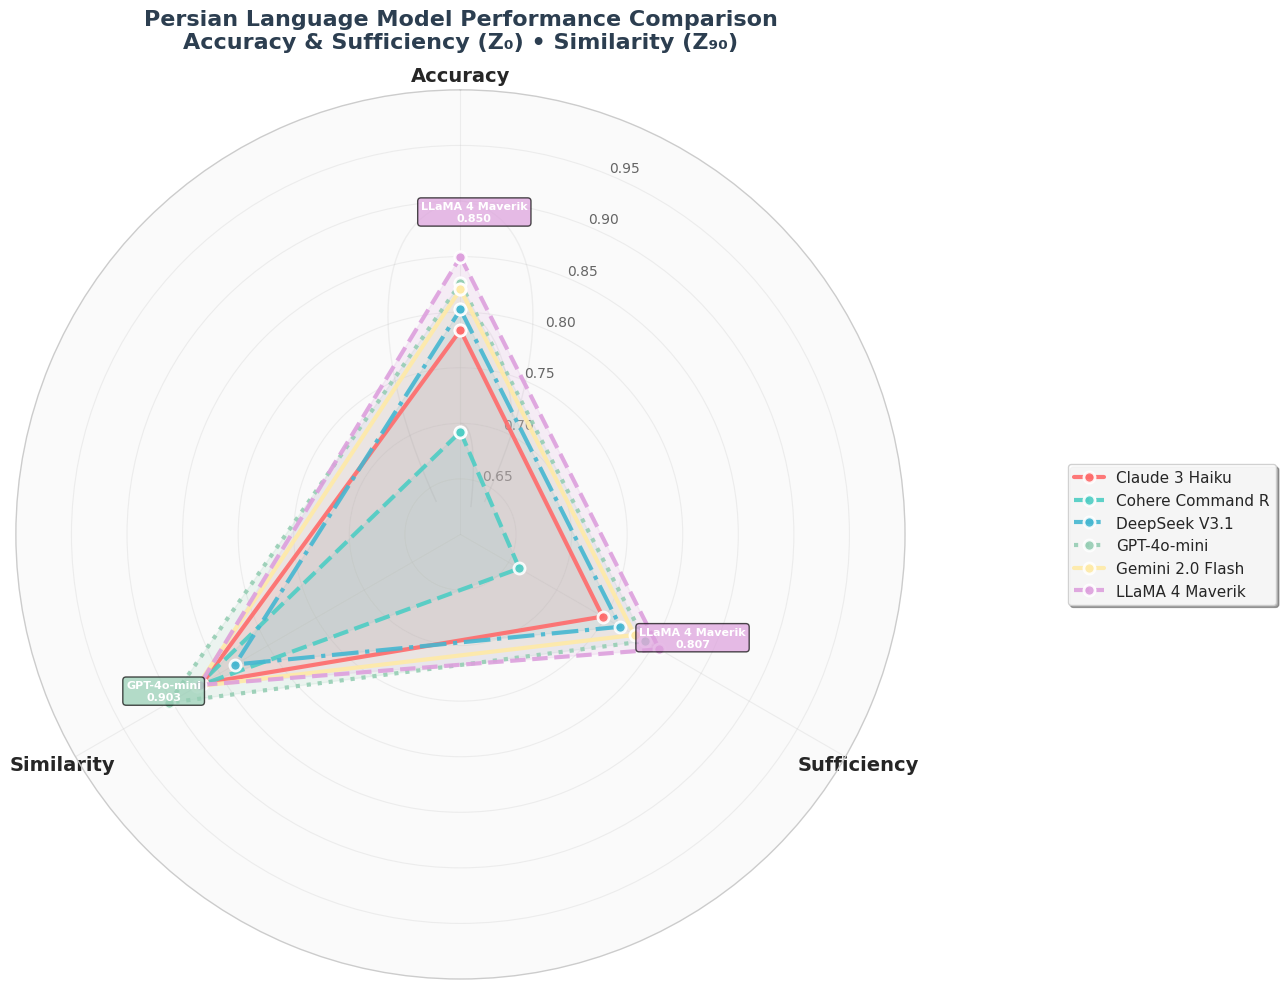

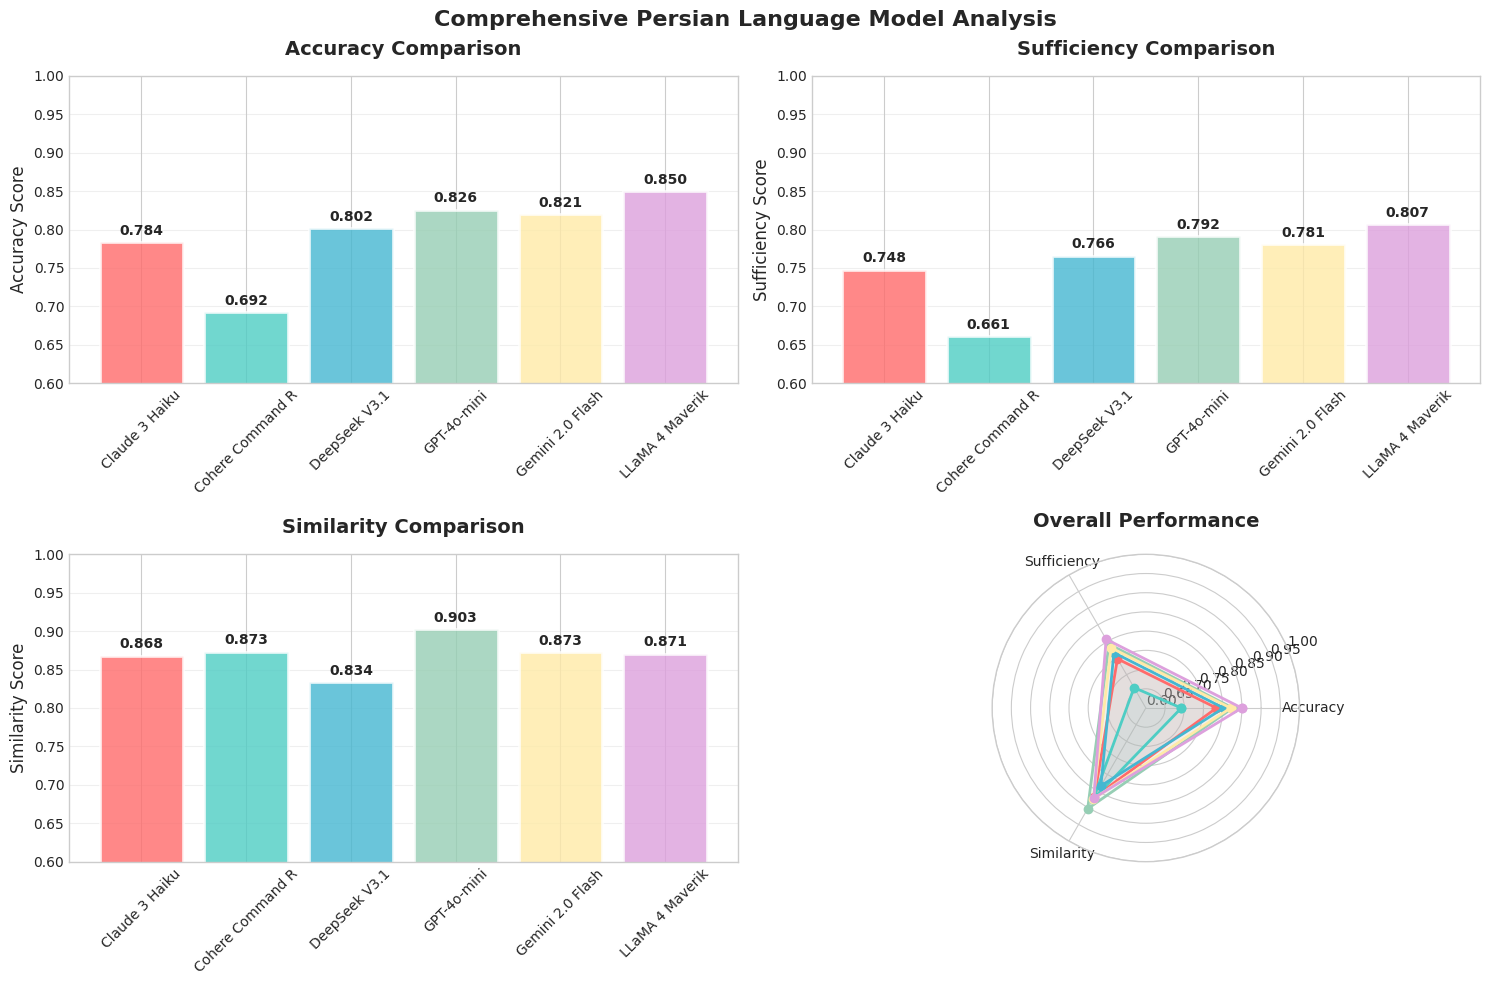

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
import seaborn as sns

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ==========================================
# Persian radar data (acc/suff @ Z0, sim @ Z90)
# ==========================================
data_fa = {
    "Model": [
        "Claude 3 Haiku",
        "Cohere Command R", 
        "DeepSeek V3.1",
        "GPT-4o-mini",
        "Gemini 2.0 Flash",
        "LLaMA 4 Maverik"
    ],
    "Accuracy": [0.7838, 0.6924, 0.8024, 0.8260, 0.8206, 0.8497],
    "Sufficiency": [0.7478, 0.6612, 0.7661, 0.7919, 0.7809, 0.8067],
    "Similarity": [0.8683, 0.8734, 0.8341, 0.9028, 0.8733, 0.8709]
}

df = pd.DataFrame(data_fa)

# ==========================================
# Enhanced Radar chart setup
# ==========================================
categories = ["Accuracy", "Sufficiency", "Similarity"]
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Create figure with larger size and better DPI
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True), dpi=100)

# Define beautiful color palette
colors = [
    '#FF6B6B',  # Coral Red
    '#4ECDC4',  # Teal
    '#45B7D1',  # Sky Blue  
    '#96CEB4',  # Mint Green
    '#FFEAA7',  # Warm Yellow
    '#DDA0DD'   # Plum
]

# Line styles for better distinction
line_styles = ['-', '--', '-.', ':', '-', '--']
line_widths = [3, 3, 3, 3, 3, 3]

# Plot each model with enhanced styling
for i, row in df.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 
           linewidth=line_widths[i], 
           linestyle=line_styles[i], 
           label=row["Model"],
           color=colors[i],
           marker='o',
           markersize=8,
           markerfacecolor=colors[i],
           markeredgecolor='white',
           markeredgewidth=2,
           alpha=0.9)
    
    ax.fill(angles, values, alpha=0.15, color=colors[i])

# Customize the radar chart appearance
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set category labels with better formatting
ax.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=14, fontweight='bold')

# Customize radial limits and grid
ax.set_ylim(0.6, 1.0)  # Focus on the actual data range
ax.set_yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
ax.set_yticklabels(['0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95'], 
                   fontsize=10, alpha=0.7)

# Add grid styling
ax.grid(True, alpha=0.3)
ax.set_facecolor('#FAFAFA')

# Enhanced title with better positioning
ax.set_title("Persian Language Model Performance Comparison\nAccuracy & Sufficiency (Z₀) • Similarity (Z₉₀)", 
            size=16, fontweight='bold', pad=30, color='#2C3E50')

# Improved legend with better positioning
legend = ax.legend(loc='center', bbox_to_anchor=(1.3, 0.5), 
                  fontsize=11, frameon=True, fancybox=True, 
                  shadow=True, framealpha=0.9)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('#CCCCCC')

# Add subtle background circles for better visual reference
for radius in [0.7, 0.8, 0.9]:
    circle = Circle((0, 0), radius, fill=False, color='gray', alpha=0.1, linewidth=1)
    ax.add_patch(circle)

# Add performance annotations for top performers
max_values = df[categories].max()
for i, category in enumerate(categories):
    max_idx = df[category].idxmax()
    max_model = df.loc[max_idx, 'Model']
    max_val = df.loc[max_idx, category]
    
    # Add small annotation for best performer in each category
    angle_rad = angles[i]
    x_pos = angle_rad
    y_pos = max_val + 0.02
    
    ax.annotate(f'{max_model}\n{max_val:.3f}', 
               xy=(x_pos, y_pos), 
               xytext=(10, 10), 
               textcoords='offset points',
               fontsize=8, 
               ha='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[max_idx], alpha=0.7),
               color='white',
               fontweight='bold')

plt.tight_layout()



plt.show()

# ==========================================
# Alternative: Create a comparison bar chart as well
# ==========================================
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Individual metric comparisons
metrics = ['Accuracy', 'Sufficiency', 'Similarity']
for idx, metric in enumerate(metrics):
    if idx < 3:
        current_ax = [ax1, ax2, ax3][idx]
        bars = current_ax.bar(df['Model'], df[metric], color=colors, alpha=0.8, edgecolor='white', linewidth=2)
        current_ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=15)
        current_ax.set_ylabel(f'{metric} Score', fontsize=12)
        current_ax.set_ylim(0.6, 1.0)
        current_ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            current_ax.annotate(f'{height:.3f}',
                              xy=(bar.get_x() + bar.get_width() / 2, height),
                              xytext=(0, 3),
                              textcoords="offset points",
                              ha='center', va='bottom',
                              fontweight='bold', fontsize=10)
        
        current_ax.tick_params(axis='x', rotation=45)

# Overall performance radar in the 4th subplot
ax4.remove()
ax4 = fig2.add_subplot(2, 2, 4, polar=True)

# Compute overall scores
df['Overall'] = df[categories].mean(axis=1)

for i, row in df.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax4.plot(angles, values, linewidth=2, label=row["Model"], color=colors[i], marker='o')
    ax4.fill(angles, values, alpha=0.1, color=colors[i])

ax4.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=10)
ax4.set_title("Overall Performance", fontsize=14, fontweight='bold', pad=20)
ax4.set_ylim(0.6, 1.0)

plt.suptitle('Comprehensive Persian Language Model Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [26]:
merged_wide = (
    merged_df
    .pivot(index="version", columns="model", values=["accuracy_exp", "sufficiency", "similarity_clean"])
)

merged_wide

accuracy_exp                                             \
model   Claude 3 Haiku Cohere Command R Deepseek V3.1 GPT 4o mini   
version                                                             
0             0.783805         0.692367      0.802402    0.826036   
10            0.688493         0.613328      0.667571    0.645486   
20            0.719101         0.631926      0.693142    0.679194   
30            0.745060         0.648586      0.717939    0.710190   
40            0.749322         0.672220      0.728787    0.731112   
50            0.750872         0.666796      0.742348    0.749709   
60            0.760558         0.670670      0.738473    0.753584   
70            0.765595         0.675707      0.747385    0.767532   
80            0.765207         0.683069      0.759008    0.775668   
90            0.764820         0.680356      0.767532    0.782255   

                                                            sufficiency  \
model   Gemini 2.0 flash LLAMA 4 Scout Mistral 3.1 Small Claude 3 Haiku   
version                                                                   
0               0.820612      0.796203          0.750484       0.747764   
10              0.692755      0.685006          0.624177       0.651099   
20              0.736149      0.706703          0.658272       0.685721   
30              0.760558      0.719876          0.674157       0.708011   
40              0.781480      0.730337          0.693142       0.716315   
50              0.797365      0.745835          0.698179       0.720418   
60              0.800852      0.743123          0.701279       0.724539   
70              0.807826      0.757071          0.717164       0.728309   
80              0.803177      0.757846          0.707865       0.729720   
90              0.809764      0.763657          0.721813       0.728880   

                                        ...                                 \
model   Cohere Command R Deepseek V3.1  ... Gemini 2.0 flash LLAMA 4 Scout   
version                                 ...                                  
0               0.661227      0.766077  ...         0.780864      0.758107   
10              0.576517      0.621031  ...         0.650338      0.643404   
20              0.601882      0.649168  ...         0.693264      0.668596   
30              0.617286      0.670463  ...         0.718593      0.682933   
40              0.633912      0.685542  ...         0.740963      0.692573   
50              0.635008      0.694888  ...         0.751521      0.708273   
60              0.637668      0.699196  ...         0.758141      0.706919   
70              0.644664      0.703200  ...         0.763811      0.717977   
80              0.649870      0.713849  ...         0.765482      0.720668   
90              0.648612      0.721202  ...         0.768477      0.726787   

                          similarity_clean                                 \
model   Mistral 3.1 Small   Claude 3 Haiku Cohere Command R Deepseek V3.1   
version                                                                     
0                0.716347              NaN              NaN           NaN   
10               0.584414         0.641761         0.525559      0.570013   
20               0.618446         0.746146         0.656978      0.654810   
30               0.641659         0.796191         0.729514      0.707658   
40               0.649619         0.826505         0.777698      0.743207   
50               0.660237         0.844635         0.807805      0.772465   
60               0.667800         0.851756         0.827879      0.789537   
70               0.673798         0.854943         0.845101      0.805601   
80               0.673157         0.862874         0.860100      0.820477   
90               0.687929         0.868333         0.873420      0.834147   

                                                                      
model   GPT 4o mini Gemini 2.0 flash LLAMA 4 Sco

In [27]:
import pandas as pd

all_dfs = []
for model_name, df in dfs.items():
    # فقط ستون‌های لازم رو نگه می‌داریم
    sub = df[["version", "accuracy_exp", "sufficiency", "similarity_clean"]].copy()
    sub["model"] = model_name   # اضافه کردن نام مدل
    all_dfs.append(sub)

# ادغام همه دیتافریم‌ها
merged_df = pd.concat(all_dfs, ignore_index=True)

merged_df.head()


,version,accuracy_exp,sufficiency,similarity_clean,model
0,0,0.783805,0.747764,NaN,Claude 3 Haiku
1,10,0.688493,0.651099,0.641761,Claude 3 Haiku
2,20,0.719101,0.685721,0.746146,Claude 3 Haiku
3,30,0.745060,0.708011,0.796191,Claude 3 Haiku
4,40,0.749322,0.716315,0.826505,Claude 3 Haiku


                  accuracy_exp  sufficiency  similarity_clean
accuracy_exp          1.000000     0.948001          0.556495
sufficiency           0.948001     1.000000          0.577061
similarity_clean      0.556495     0.577061          1.000000


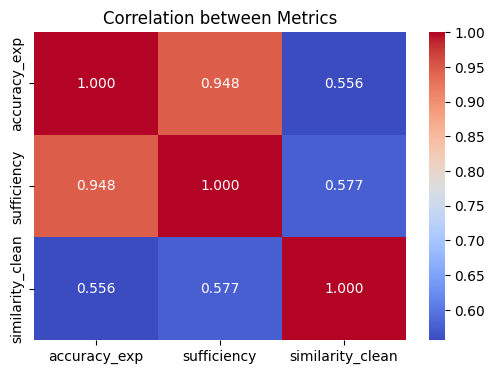

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# محاسبه ماتریس همبستگی
corr = merged_df[["accuracy_exp", "sufficiency", "similarity_clean"]].corr(method="kendall")
print(corr)

# نمایش بصری
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation between Metrics")
plt.show()


In [29]:
import pandas as pd
df = pd.read_csv('/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa_with_goldprob/llama/eval_llama_4_maverik_masked_80_with_goldprob.csv')

In [30]:
corr_rows = df[["is_correct_exp", "gold_prob_exp"]].corr('pearson')
print("\nRow-level correlation:\n", corr_rows)


Row-level correlation:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.910536
gold_prob_exp         0.910536       1.000000


In [42]:
# Pearson (default)
pearson_corr = df[["is_correct_exp", "gold_prob_exp"]].corr(method="pearson")
print("Pearson:\n", pearson_corr)

# Spearman
spearman_corr = df[["is_correct_exp", "gold_prob_exp"]].corr(method="spearman")
print("\nSpearman:\n", spearman_corr)

# Kendall
kendall_corr = df[["is_correct_exp", "gold_prob_exp"]].corr(method="kendall")
print("\nKendall:\n", kendall_corr)


Pearson:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.910536
gold_prob_exp         0.910536       1.000000

Spearman:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.702489
gold_prob_exp         0.702489       1.000000

Kendall:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.573692
gold_prob_exp         0.573692       1.000000
